# Question 3

A model for the flow rate of water (in $m^3$/year) through a borehole is given by the following equation:


\begin{equation*}
y(\boldsymbol{\theta}) =
\frac{2\pi T_u \left(H_u - H_l\right)}
{\ln\left(\frac{r}{r_w}\right)\left(1 + \frac{2LT_u}{\ln\left(\frac{r}{r_w}\right)r_w^2K_w} + \frac{T_u}{T_l}\right)}
\end{equation*}

There are 8 parameters which are all independent except $T_u$ and $T_l$ which are correlated with a coefficient of correlation of 0.4, and $H_u$, which is conditional on $H_l$. The parameter vector $\boldsymbol{\theta}$ is defined as $\left[r_w, r, T_u, H_u, T_l, H_l, L, K_w \right]$. 

The probability that the flow rate will exceed a threshold $\beta$ is given by:


\begin{equation*}
P\left(y \ge \beta \right) = \int I\left[y(\boldsymbol{\theta}) \ge \beta \right] p(\boldsymbol{\theta})d\boldsymbol{\theta}
\end{equation*}

This will be denoted as: 

\begin{equation*}
\alpha = \int f(\boldsymbol{\theta}) p(\boldsymbol{\theta})d\boldsymbol{\theta}
\end{equation*}

for convenience.

### (a) A computer program in Python using a direct Monte Carlo method with 1000 samples to calculate $P\left(y \ge \beta_1 \right)$ for $\beta_1$ = 150 $m^3$/year 

#### Importing modules

In [1]:
from scipy.stats import lognorm, uniform, gaussian_kde
from scipy.stats import norm as gaussian
from scipy.stats import multivariate_normal as mvn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import time

#### Building the distributions for the model parameters

In [2]:
rw = uniform(loc=0.1, scale=(0.2-0.1))
r = lognorm(s=2, scale=np.exp(5))
tu = gaussian(loc=89000, scale=8900)
hl = uniform(loc=700, scale=(820-700))
tl = gaussian(loc=89, scale=8.9)
hu = uniform(loc=0, scale=(200-100))
l = uniform(loc=1120, scale=(1680-1120))
kw = uniform(loc=9500, scale=(13000-9500))

dists = [rw, r, tu, hl, tl, hu, l, kw]

m1 = 89000
m2 = 89
s1 = 8900
s2 = 8.9
rho = 0.4

cov = np.array([[s1**2, rho*s1*s2], [rho*s1*s2, s2**2]])
mean = np.array([m1, m2])

tu_tl = mvn(mean=mean, cov=cov)

#### Plotting the pdfs of the parameters

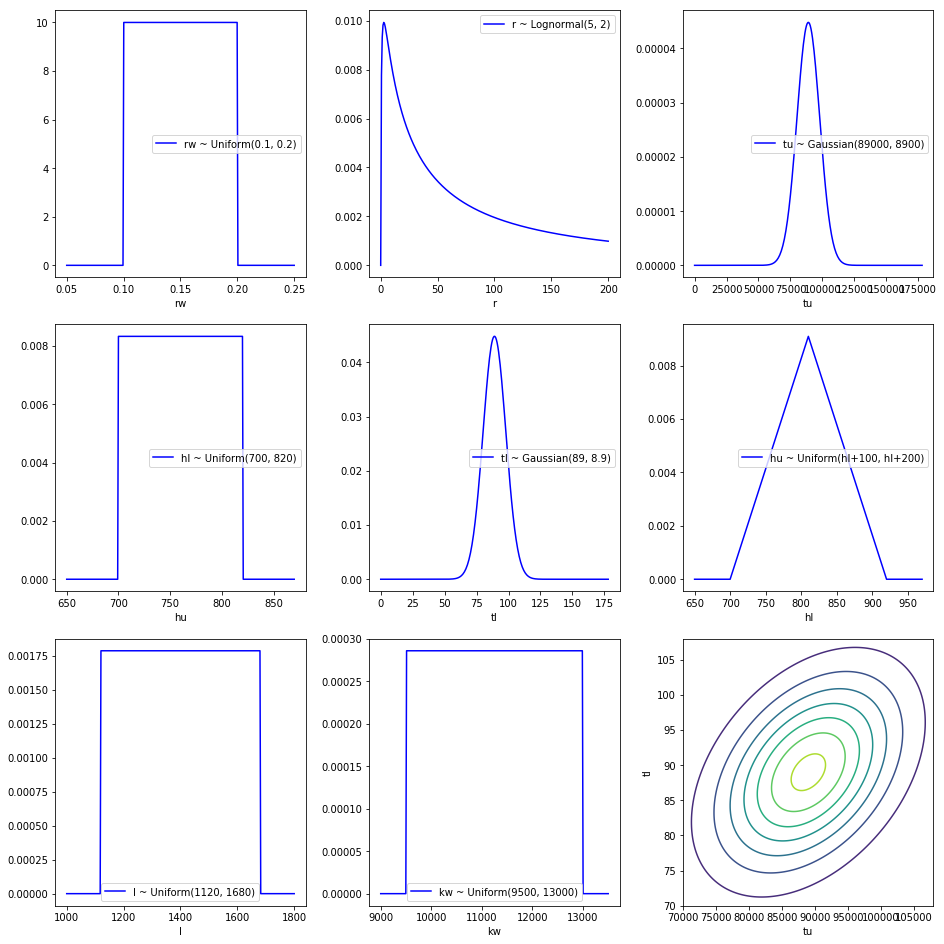

In [3]:
# Variables used for defining the plots
par_names = ["rw", "r", "tu", "hu", "tl", "hl", "l", "kw"]
labels = ["rw ~ Uniform(0.1, 0.2)", "r ~ Lognormal(5, 2)", 
          "tu ~ Gaussian(89000, 8900)", "hl ~ Uniform(700, 820)", 
          "tl ~ Gaussian(89, 8.9)", "hu ~ Uniform(hl+100, hl+200)", 
          "l ~ Uniform(1120, 1680)", "kw ~ Uniform(9500, 13000)"]
lower = [0.05, 0, 0, 650, 0, 650, 1000, 9000]
upper = [0.25, 200, 2*89000, 870, 2*89, 1120, 1800, 13500]
nrow = 3
ncol = 3
figsize = (4*ncol+1, 4*nrow+1)

# Plots
f, axs = plt.subplots(nrow, ncol, figsize=figsize, constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(dists):
        if i == 5:
            ax.plot([650, 700, 810, 920, 970], [0, 0, 1/(0.5*220), 0, 0], 'b-', label=labels[i])
        else:
            x = np.linspace(lower[i], upper[i], 300)
            ax.plot(x, dists[i].pdf(x), 'b-', label=labels[i])
        ax.set_xlabel(par_names[i])
        ax.legend()
    if i == len(dists):
        xv = np.linspace(70000, 108000, 200)
        yv = np.linspace(70, 108, 300)
        x, y = np.meshgrid(xv, yv)
        pos = np.stack((x, y), axis=-1)
        ax.contour(x, y, tu_tl.pdf(pos))
        ax.set_xlabel("tu")
        ax.set_ylabel("tl")
plt.show()

#### Defining the model

In [4]:
def flow_rate_model(rw, r, tu, hl, tl, hu, l, kw):
    numerator = 2*np.pi*tu*(hu-hl)
    denominator = np.log(r/rw)*(1 + 2*l*tu/(np.log(r/rw)*rw**2*kw) + tu/tl)
    y = numerator/denominator
    return y

#### Define the probability of exceedence

In [5]:
def prob_exceedence(samples, threshold):
    return np.sum(samples >= threshold)/np.shape(samples)[0]

#### Drawing samples from the distribution of the parameters

In [13]:
dists = [rw, r, tu, hl, tl, hu, l, kw]
nsamples = 1000
samples = [dist.rvs(nsamples) for dist in dists]
mvn_samples = tu_tl.rvs(nsamples)

samples[2] = mvn_samples[:, 0]
samples[4] = mvn_samples[:, 1]
samples[5] = samples[3] + samples[5]

#### Plotting the samples

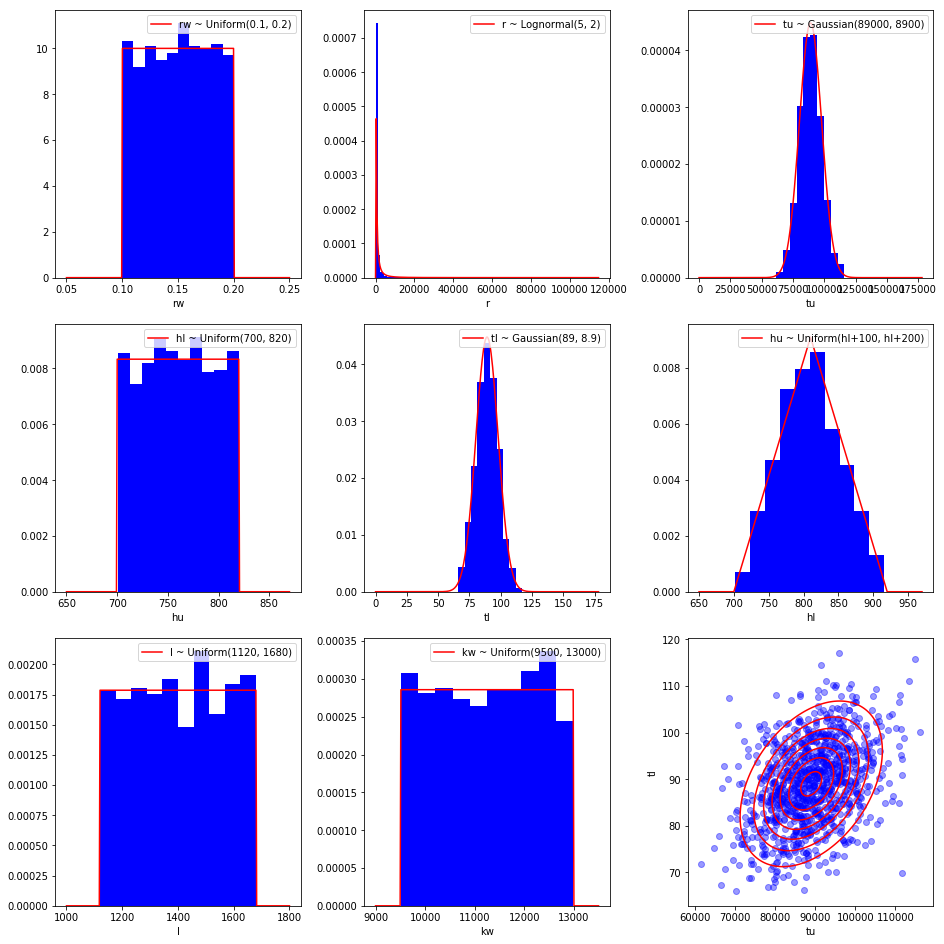

In [14]:
f, axs = plt.subplots(nrow, ncol, figsize=(4*ncol+1, 4*nrow+1), constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    if i < len(dists):
        if i == 1:
            x = np.linspace(lower[i], max(samples[i]), 300)
            ax.hist(samples[i], density=True, bins=100, color='b')
        else:
            x = np.linspace(lower[i], upper[i], 300)
            ax.hist(samples[i], density=True, color='b')
        if i == 5:
            ax.plot([650, 700, 810, 920, 970], [0, 0, 1/(0.5*220), 0, 0], 'r-', label=labels[i])
        else:
            ax.plot(x, dists[i].pdf(x), 'r-', label=labels[i])
        ax.set_xlabel(par_names[i])
        ax.legend()
    if i == len(dists):
        xv = np.linspace(70000, 108000, 200)
        yv = np.linspace(70, 108, 300)
        x, y = np.meshgrid(xv, yv)
        pos = np.stack((x, y), axis=-1)
        ax.contour(x, y, tu_tl.pdf(pos), colors='red')
        ax.scatter(samples[2], samples[4], c='b', alpha=0.4)
        ax.set_xlabel("tu")
        ax.set_ylabel("tl")
plt.show()

#### Evaluating the model

In [15]:
y = flow_rate_model(samples[0], samples[1], samples[2], samples[3], 
                    samples[4], samples[5], samples[6], samples[7])

beta_1 = 150;
beta_2 = 250;
beta_3 = 400;
thresholds = [50, 100, beta_1];
for t in thresholds:
    print("Probability of the flow rate exceeding a threshold of " + str(t) + " m^3/year is computed to be " 
          + str(prob_exceedence(y, t)) + " using " + str(np.shape(samples)[1]) + " samples.")

Probability of the flow rate exceeding a threshold of 50 m^3/year is computed to be 0.176 using 1000 samples.
Probability of the flow rate exceeding a threshold of 100 m^3/year is computed to be 0.003 using 1000 samples.
Probability of the flow rate exceeding a threshold of 150 m^3/year is computed to be 0.0 using 1000 samples.


#### Coefficient of variation of the estimator

Here, the unknown quantity which is being estimated is the probability of the flow rate exceeding a threshold i.e., $P\left(y \ge \beta \right)$. Denoting this as $\alpha$, we estimate $\alpha$ using an estimator $\hat{\alpha}$, which is a random variable whose value depends on the samples of the flow rate used in the computation. 

\begin{equation*}
\hat{\alpha} = \frac{1}{N}\sum_{i=1}^N y_i
\end{equation*}

The variance of this estimator is given by:
\begin{equation*}
Var\left(\hat{\alpha}\right) = Var\left(\frac{1}{N}\sum_{i=1}^N y_i\right) = \frac{1}{N^2} Var\left(\sum_{i=1}^N y_i\right)
\end{equation*}

Since the samples $y_i$ are independent and identically distributed, this becomes:
\begin{equation*}
\frac{1}{N^2} Var\left(\sum_{i=1}^N y_i\right) = \frac{1}{N^2} \sum_{i=1}^N Var\left(y_i\right) = \frac{1}{N^2} * N * Var\left(y_i\right) = \frac{Var\left(y_i\right)}{N}
\end{equation*}

Since $Var\left(y_i\right)$ is unknown, this is estimated by the sample variance $s^2$. Hence:
\begin{equation*}
Var\left(\hat{\alpha}\right) = \frac{s^2}{N} = \frac{s^2}{1000}
\end{equation*}
since we use 1000 samples in the estimator.

In [17]:
sample_variance = np.var(y)
print("The estimated variance of the estimator is: ", sample_variance/nsamples, " (m^3/year)^2.")

The estimated variance of the estimator is:  0.4714943687291869  (m^3/year)^2.


### (b) Approximating the probability density of the flow rate using the same sample set

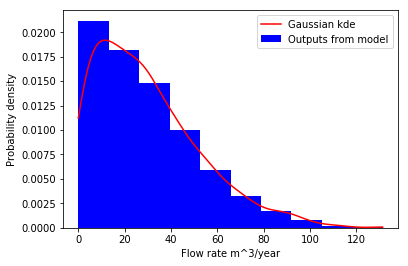

In [8]:
plt.hist(y, density=True, color='b', label='Outputs from model')
x = np.linspace(0, max(y), 100)
kde = gaussian_kde(y)
plt.plot(x, kde(x), 'r-', label='Gaussian kde')
plt.xlabel("Flow rate m^3/year")
plt.ylabel("Probability density")
plt.legend()
plt.show()

### (c) Importance sampling

#### Visualizing the dataset

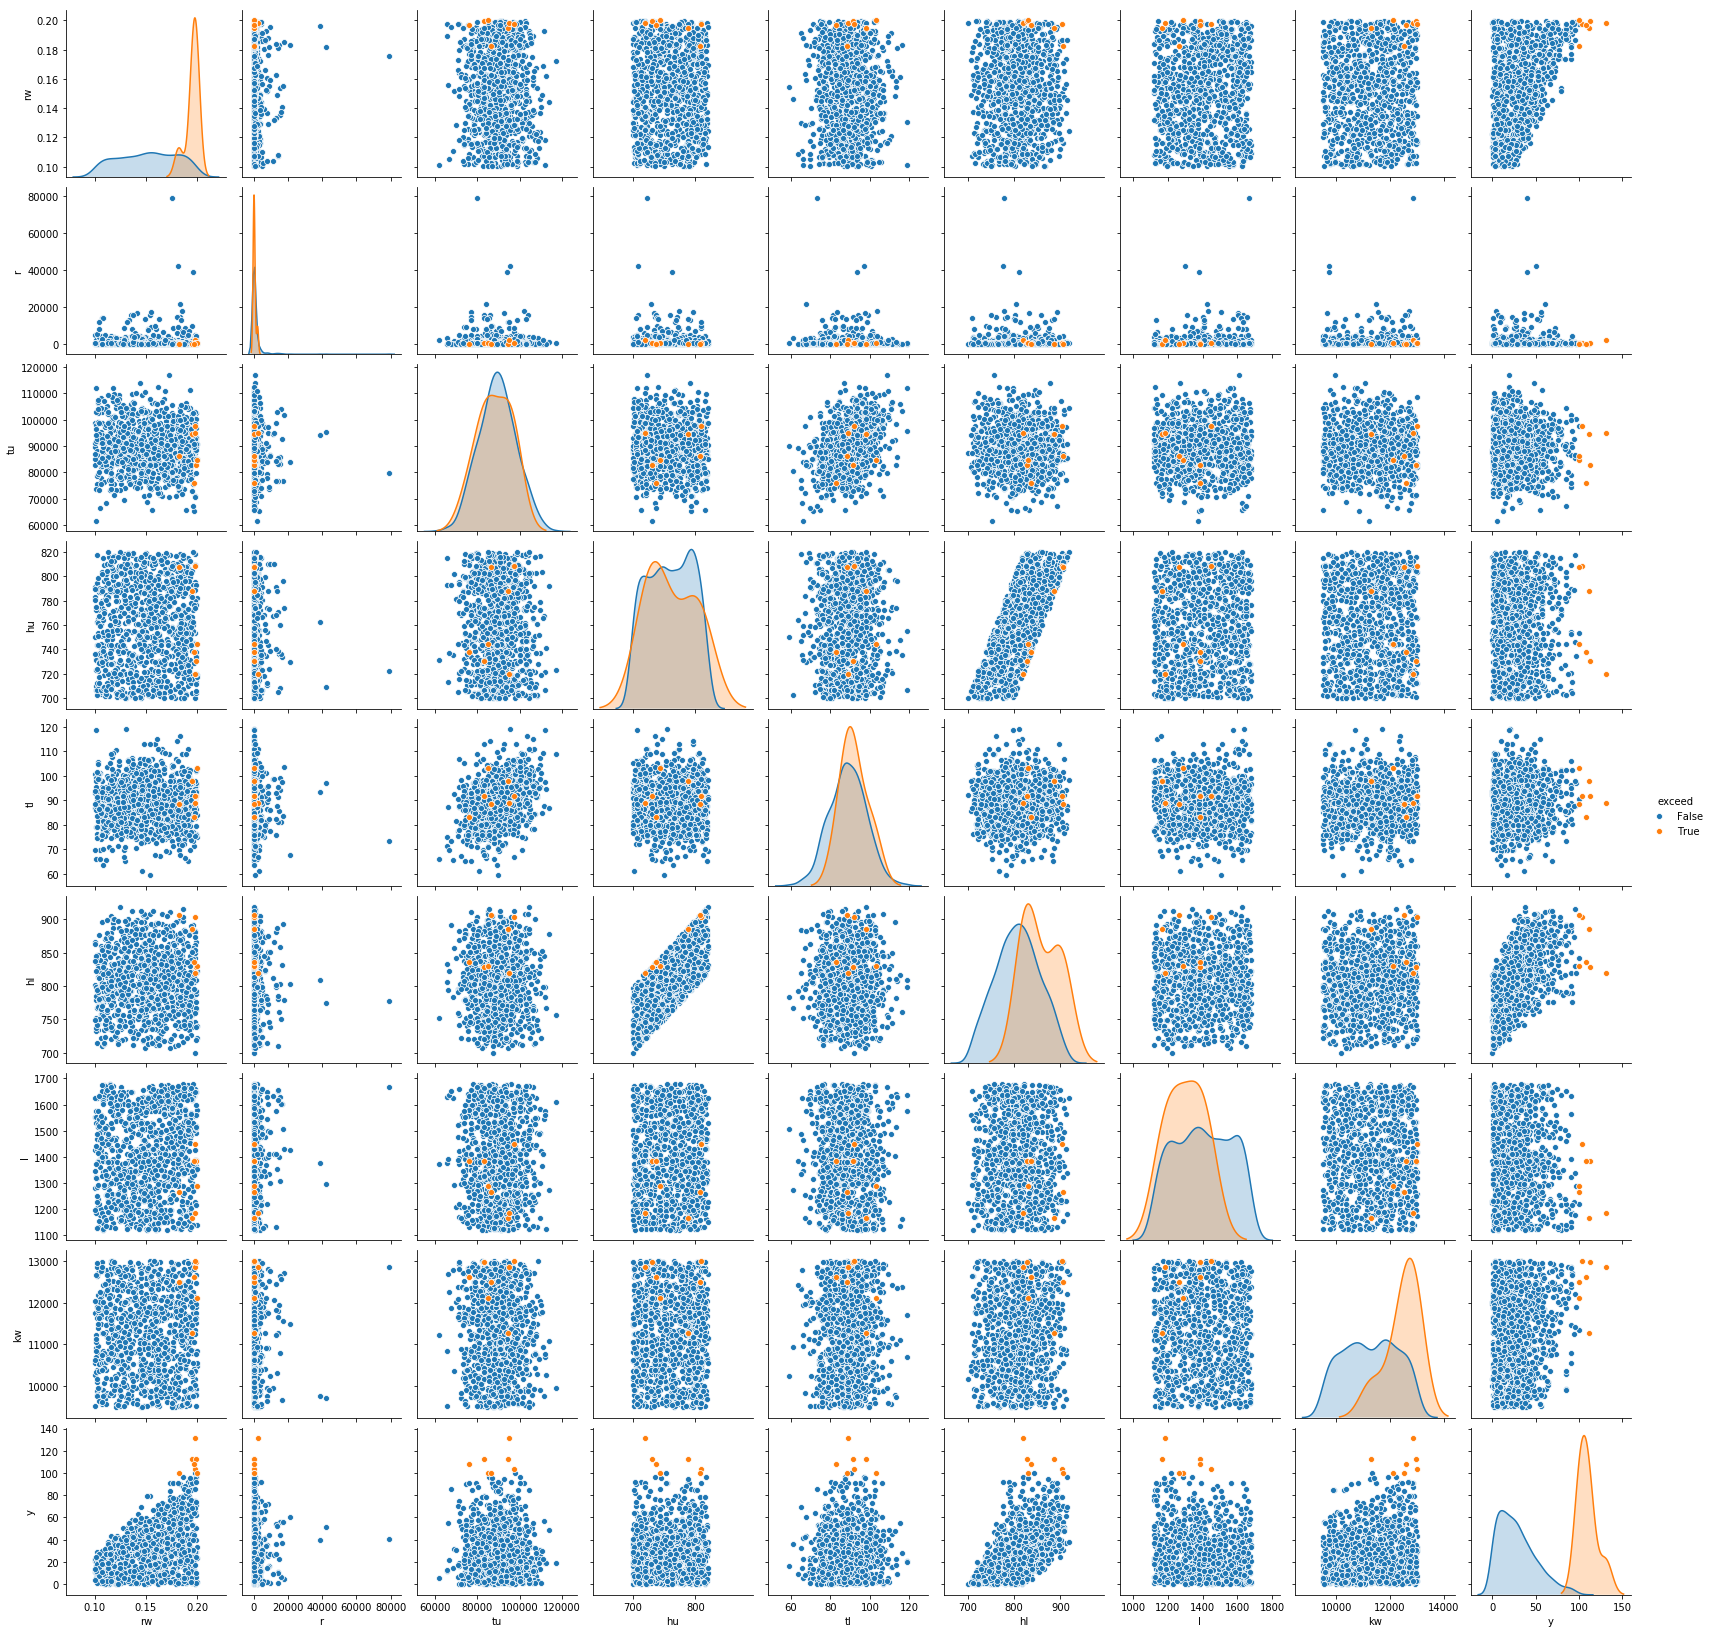

In [12]:
s = np.array(samples).T
df = pd.DataFrame(s, columns=["rw", "r", "tu", "hu", "tl", "hl", "l", "kw"])
df["y"] = y
df["exceed"] = y >= 100
df.head()
g = sns.pairplot(df, corner=False, diag_kind="kde", hue="exceed")

### (f) Drawing samples from the posterior $p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D})$

#### Reading the input and output data

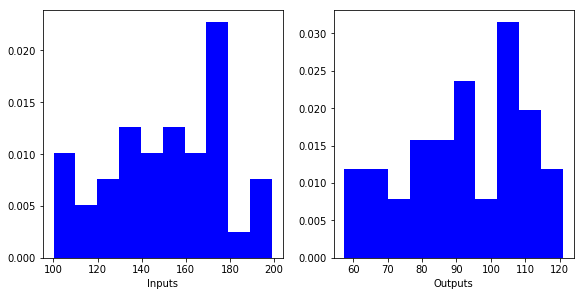

In [10]:
inputs = np.loadtxt("input.txt")
outputs = np.loadtxt("output.txt")

fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axs[0].hist(inputs, density=True, color='b')
axs[0].set_xlabel("Inputs")
axs[1].hist(outputs, density=True, color='b')
axs[1].set_xlabel("Outputs")

plt.show()

The posterior probability $p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D})$ is given by Bayes' rule as: 
\begin{equation*}
p(\boldsymbol{\theta}_m, \sigma_e | \boldsymbol{D}) = \frac{p(\boldsymbol{D} | \boldsymbol{\theta}_m, \sigma_e) p(\boldsymbol{\theta}_m, \sigma_e)}{p(\boldsymbol{D})} 
\end{equation*}
where, $p(\boldsymbol{D}) = \int {p(\boldsymbol{D} | \boldsymbol{\theta}_m, \sigma_e) p(\boldsymbol{\theta}_m, \sigma_e)}$.


#### Using Gibbs sampling to draw samples from the posterior